Cosa faremo:

andiamo a creare un dataset che, data un'immagine, genera le due versioni augmented. Prendiamo un dataset in modo da darci in output due versioni augmented della stessa immagine.

La seconda parte del laboratorio è sull'encoder, implementiamo una siamese network. Ci sono due versioni: una è simmetrica, l'altra è con assimetria (un encoder è l'online/student e l'altro è il teacher/target, qui c'è sbilanciamento delle reti)

Ultima parte del lab verte su implementare le loss: SimCLR, BYOL e Barlow Twins

Infine vedremo la parte di evaluation di questi modelli

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms as transforms

import torchvision
import torchvision.models as models
#import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
from torchvision.io import read_image



from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision.transforms as transforms

# come ci si collega
# ssh nome_account@macchina.micc.unifi.it # yoda e windu
# mettere pw
# usare github


In [2]:
# FUNZIONE VECCHIA

# come funziona un'interazione fra un dataset e un dataloader su pytorch?
# il dataset memorizza le stringhe dei path. il dataset si prende in input i dati, ovvero i path, oppure degli array (come in CIFAR10)
# il dataloader crea i batch, è un estrattore di dati dal dataset. Li estrae così: ogni dataset va a implementare una funzione getItem(), ogni dataloader la va a chiamare. Dentro questa funzione si va a specificare
# tutti i passaggi che si deve fare per processare un determinato dato (immagine). Di solito, nel caso supervisionato, si restituisce sia l'immagine che la label. Nel caso non supervisionato il return non avrà ovviamente label perchè non ci sono!!


class CustomImageDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.imgs = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx): # override funzione getItem(), qui si dicono tutti i passaggi che devono essere fatti per processare un dato # idx me lo dice il dataloader, indici
        img = imgs[idx] # data un'immagine in input, in output voglio in output due versioni augmeted della stessa immagine # di questi indici, viene fatto un filtering, di ogni immagine voglio due versioni augmented della stessa immagine!!
        if isinstance(img, str):
          image = read_image(img_path) # questa è giusta tenerla, se un elemento preso è una stringa (path), carico l'immagine
        label = self.targets[idx] # in generale non servono
        if self.transform: # fa un controllo e vede se è NaN o no. Di default è NaN, dobbiamo usare questa trasformazione per l'immagine
            image = self.transform(image)
        if self.target_transform: # si può togliere, si usa raramente # si usa quando: se le label sono stringhe, spesso il mapping delle stringhe è un id intero
            label = self.target_transform(label)
        return image, label # nel caso unsupervised non ci saranno le label, non le abbiamo!!


# DL con n = 100 b = 8 in 4 classi, il DL va a estrarmi 8 elementi fra queste 100 immagini, fa un sampling bilanciato, stessi elementi per classe (qui 2). es B1 [0, 1, 25, 26. 50, 51, 75, 76] - supposto che i dati siano in ordine -
# con label y = 0, 1, 2, 3 [che non usiamo qui]. Dell'elemento 0 voglio la versione x0_cappello e x0_tilde, il mio batch alla fine in uscita dovrà avere 16 immagini
# è per questo che bisogna fissare bene il numero di workers, se ne mettiamo pochi (1) se ho un dataset di 2048, verrà eseguito in modo sequenziale 2048 volte ogni volta che si va ad estrarre un batch. PER QUESTO N_WORKERS ALTI!

# dobbiamo implementare getItem() per avere in output due versioni augmented della stessa immagine

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, data, targets = None, transform=None, target_transform=None): # valori di default
        self.imgs = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if isinstance(img, str):
          image = read_image(img)
        else:
          image = Image.fromarray(img.astype('uint8'), 'RGB') # trasforma un qualsiasi input array come un'immagine RGB
        if self.transform: # arriva qui con una PIL image, si fanno due trasformazioni 
            image1 = self.transform(image) # fa due trasformazioni
            image2 = self.transform(image)
        else: # qui non viene applicata la trasformazione, ritorna la stessa immagine
            image1 = image
            image2 = image
        return image1, image2

In [ ]:
# vogliamo creare due versioni augmented

data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True) # dataset

# simclr DA pipeline
# come le voglio augmentare

#size = 32

color_jitter = transforms.ColorJitter(0.8, 0.8, 0.8, 0.2) # si distorce il colore con una certa probabilità tutti i canali

# come andiamo a aumentare le immagini
transform = transforms.Compose([transforms.RandomResizedCrop(size=32),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomApply([color_jitter], p=0.8),
                                  transforms.RandomGrayscale(p=0.2),
                                  transforms.GaussianBlur(kernel_size=int(0.1 * 32)),
                                  transforms.ToTensor()])


# create training set from CustomDataset

# instanziare un trainset che segua la struttura del codice del blocco precedente

trainset = CustomImageDataset(data.data, transform = transform)

#trainset, valset = torch.utils.data.random_split(data, [40000, 10000]) # dataset, numero immagini train 40000 e validation 10000, in uscita avrò due dataset



In [ ]:
data.data.shape # restituisce tutte le nostre immagini, è un array

(50000, 32, 32, 3)

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

img1 batch shape: torch.Size([64, 3, 32, 32])
img2 batch shape: torch.Size([64, 3, 32, 32])


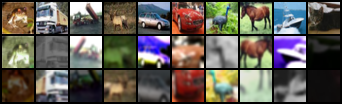

In [ ]:
# Display image and label.
# va modificato

import matplotlib.pyplot as plt


# DA CAMBIARE

train_img1, train_img2 = next(iter(dataloader)) # si fa iterazione del dataloader

print(f"img1 batch shape: {train_img1.size()}")
print(f"img2 batch shape: {train_img2.size()}")
img1 = train_img1[:10]
img2 = train_img2[:10]


# imshow(img1, cmap="gray")
# plt.show()


# use this
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)


from torchvision.utils import make_grid
imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)],
                    *[trainset[i][1] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

## Exercise 1
Create the custom training set using the cifar10 images and targets

## Exercise 2
Modify the custom dataset to return two different views of an input image and create a train loop as the following example

come metterlo dentro il training loop, come si modifica

In [ ]:
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

# è come ci ritroviamo i dati qui dentro

# stessa cosa di fare next(iter(train_dataloader)), è come fare 1 solo loop

'''
for idx, data in enumerate(dataloader):
    images, targets = data # uscita dataset per n elementi
    print(images.shape)
    print(targets.shape)
    if idx == 3: # n_batch = 3 -> 3 immagini e 3 target
        break
'''



for idx, data in enumerate(dataloader):
    view1, view2 = data # uscita dataset per n elementi
    print(f"batch {idx}:")
    print(view1.shape)
    print(view2.shape, end="\n\n")
    if idx == 3: # n_batch = 3 -> 3 immagini e 3 target
        break

batch 0:
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])

batch 1:
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])

batch 2:
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])

batch 3:
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])

